#Crop Image with OpenCV 



#step1 Subset Data
subset 데이터를 복사하여 압축을 풉니다. 

In [15]:
!pwd

/home/ubuntu/notebook/class4


In [16]:
!cp ~/dlday/imgs_subset.zip ./.

In [17]:
!unzip imgs_subset.zip

Archive:  imgs_subset.zip
   creating: imgs_subset/
  inflating: imgs_subset/w_0.jpg     
  inflating: imgs_subset/w_1.jpg     
  inflating: imgs_subset/w_10.jpg    
  inflating: imgs_subset/w_100.jpg   
  inflating: imgs_subset/w_101.jpg   
  inflating: imgs_subset/w_102.jpg   
  inflating: imgs_subset/w_103.jpg   
  inflating: imgs_subset/w_104.jpg   
  inflating: imgs_subset/w_105.jpg   
  inflating: imgs_subset/w_106.jpg   
  inflating: imgs_subset/w_107.jpg   
  inflating: imgs_subset/w_108.jpg   
  inflating: imgs_subset/w_109.jpg   
  inflating: imgs_subset/w_11.jpg    
  inflating: imgs_subset/w_110.jpg   
  inflating: imgs_subset/w_111.jpg   
  inflating: imgs_subset/w_112.jpg   
  inflating: imgs_subset/w_113.jpg   
  inflating: imgs_subset/w_114.jpg   
  inflating: imgs_subset/w_115.jpg   
  inflating: imgs_subset/w_116.jpg   
  inflating: imgs_subset/w_117.jpg   
 extracting: imgs_subset/w_118.jpg   
  inflating: imgs_subset/w_119.jpg   
  inflating: imgs_subset/w_12.jpg   

#step2 import openCV moudle

파이썬에서 openCV 모듈 이외에 필요한 matplotlib, numpy 등 필요한 모듈을 로드합니다. 



In [20]:
%matplotlib inline

import os
from zipfile import ZipFile 
from PIL import Image 
from StringIO import StringIO
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import imghdr

폴더 혹은 압축파일을 선택합니다. 또한, 위치계산을 위해 15% resize를 수행합니다. 
만약, class2에서 resize 작업이 된 파일이 있으시면 이를 이용해도 됩니다

In [21]:
archive_name = 'imgs_subset'
resize_factor = 0.15

# Stpe3 Class Frame
이미지 Detection을 위해 필요한 처리를 위한 Class 를 정의합니다. 

주요 함수는 다음과 같습니다. 
파일열기, 저장 등의 기본 동작 opencv와 matplotlib, numpy의 데이터 구조( RGB 구조 차이 )과 관련된 유틸리티 함수
blur, edge detect 등의 image processing 함수 
bounding box 값 추출 및 draw 및 crop 함수 


In [22]:
class Frame:
    def __init__(self, file_name, image_data):
        self.file_name = file_name
        
        pil_image = Image.open(image_data)
        image_data = np.array(pil_image)
        pil_image.close()
        
        self.image = image_data
        self.backup_image = np.empty
        self.edged = np.empty
        self.boxed_image = np.empty
        self.object_position = (0, 0, 0, 0)
        
        self.debug_image = np.empty
        
    def resize(self, resize_factor):
        height, width = self.image.shape[:2]
        self.image = cv2.resize(self.image, (int(width * resize_factor), int(height * resize_factor)))
        self.edged = np.zeros(self.image.shape[:2], dtype='uint8')
        
    def backup(self):
        self.backup_image = np.copy(self.image)
        
    def convert(self, mode):
        self.image = cv2.cvtColor(self.image, mode)
        self.debug_image = np.copy(self.image)
        
    def blur(self, blur_size):
        self.image = cv2.GaussianBlur(self.image, (blur_size, blur_size), 1)
        
    def edge(self):
        for channel in cv2.split(self.image):
            edged = cv2.Canny(channel, 90, 210)
            self.edged = cv2.bitwise_or(self.edged, edged)
        
    def drawBox(self):
        cnts, hierarchy = cv2.findContours(self.edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        if len(cnts) > 0:
            cnt = max(cnts, key = cv2.contourArea)
            x, y, w, h = cv2.boundingRect(cnt)
            self.boxed_image = np.copy(self.backup_image)
            cv2.rectangle(self.boxed_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            self.object_position = x, y, w, h
            
            return True
        else:
            return False
            
    def crop(self):
        x, y, w, h = self.object_position
        self.image = self.backup_image[y : y + h, x : x + w]
        
    def save(self, output_path):
        file_path = os.path.join(output_path, self.file_name)
        try:
            image = Image.fromarray(self.image)
            image.save(file_path, 'jpeg')
            print('Saved image to ' + file_path)
        except:
            print 'File save error on ' + file_path
            file_path = ""
        
        return file_path

# Processing

proc 함수를 통해서 작업 처리  순서를 정의합니다.
resize, convert, blur, edge detect, drawbox, crop, save 순으로 작업됩니다.

이외에 폴더/파일 핸들링 함수와 화면 출력용 함수가 정의되어 있습니다. 

In [23]:
class Processing:
    def __init__(self, archive_name, 
                 resize_factor = 0.15, 
                 convert_mode = cv2.COLOR_BGR2HSV,
                 blur_size = 9,
                 output_path = 'imgs_subset_train'):
        self.archive_name = archive_name
        self.resize_factor = resize_factor
        self.convert_mode = convert_mode
        self.blur_size = blur_size
        self.output_path = output_path
        
        self.ls_frame = []
        
    def proc(self, file_name, image_data):
        frame = Frame(file_name, image_data)
        frame.resize(self.resize_factor)
        frame.backup()
        frame.convert(self.convert_mode)
        frame.blur(self.blur_size)
        frame.edge()
        frame.drawBox()
        frame.crop()
        frame.save(self.output_path)

        self.ls_frame.append(frame)
                
    def run_dir(self, image_directory = 'imgs_subset'):
        for file_name in os.listdir(image_directory):
            image_file_path = os.path.join(image_directory, file_name)
            if imghdr.what(image_file_path) == 'jpeg':
                self.proc(file_name, image_file_path)
        
    def run_zip(self):
        with ZipFile(self.archive_name, 'r') as archive:
            for image_file in archive.namelist()[1:]:
                file_name = image_file.split('/')[-1]                
                self.proc(file_name, StringIO(archive.read(image_file)))
                
    def create_output_directory(self):
        try:
            (destination) = os.makedirs( self.output_path, 0755 )
        except OSError:
            print "Skipping creation of %s because it exists already." % self.output_path
                
    def run(self):
        self.create_output_directory()
        
        if os.path.isdir(self.archive_name):
            print 'running object detection from directory'
            self.run_dir()
        elif self.archive_name.lower().endswith('.zip'):
            print 'running object detection from zip archive file'
            self.run_zip()
        else:
            print 'unknown archive type'
            
    def view_image(self, img_idx):
        plt.subplot(1, 4, 1)
        plt.imshow(self.ls_frame[img_idx].backup_image)
        plt.xlabel('original')

        plt.subplot(1, 4, 2)
        plt.imshow(self.ls_frame[img_idx].edged)
        plt.xlabel('edged')

        plt.subplot(1, 4, 3)
        plt.imshow(self.ls_frame[img_idx].boxed_image)
        plt.xlabel('boxed')

        plt.subplot(1, 4, 4)
        plt.imshow(self.ls_frame[img_idx].image)
        plt.xlabel('cropped')

        plt.show()
        
    def view_multiple_image(self, num_view, num_image, img_idx = -1):
        for idx in range(num_view):
            img_idx = random.randrange(0, num_image)

            plt.subplot(num_view, 4, idx * 4 + 1)
            plt.imshow(self.ls_frame[img_idx].backup_image)
            plt.xlabel('original')
            plt.ylabel(img_idx)

            plt.subplot(num_view, 4, idx * 4 + 2)
            plt.imshow(self.ls_frame[img_idx].edged)
            plt.xlabel('edged')

            plt.subplot(num_view, 4, idx * 4 + 3)
            plt.imshow(self.ls_frame[img_idx].boxed_image)
            plt.xlabel('boxed')

            plt.subplot(num_view, 4, idx * 4 + 4)
            plt.imshow(self.ls_frame[img_idx].image)
            plt.xlabel('cropped')

        plt.show()

# 작업 시작 
작업을 수행합니다.  작업을 모두 마치는데는 약 1분 정도의 시간이 소요됩니다. 

In [24]:
img_proc = Processing('imgs_subset')
img_proc.run()

running object detection from directory
Saved image to imgs_subset_train/w_54.jpg
Saved image to imgs_subset_train/w_296.jpg
Saved image to imgs_subset_train/w_324.jpg
Saved image to imgs_subset_train/w_369.jpg
Saved image to imgs_subset_train/w_152.jpg
Saved image to imgs_subset_train/w_244.jpg
Saved image to imgs_subset_train/w_306.jpg
Saved image to imgs_subset_train/w_353.jpg
Saved image to imgs_subset_train/w_377.jpg
Saved image to imgs_subset_train/w_82.jpg
Saved image to imgs_subset_train/w_301.jpg
Saved image to imgs_subset_train/w_231.jpg
Saved image to imgs_subset_train/w_354.jpg
Saved image to imgs_subset_train/w_75.jpg
Saved image to imgs_subset_train/w_61.jpg
Saved image to imgs_subset_train/w_14.jpg
Saved image to imgs_subset_train/w_46.jpg
Saved image to imgs_subset_train/w_482.jpg
Saved image to imgs_subset_train/w_404.jpg
Saved image to imgs_subset_train/w_24.jpg
Saved image to imgs_subset_train/w_270.jpg
Saved image to imgs_subset_train/w_497.jpg
Saved image to imgs_s

## Results

작업처리 결과를 살펴볼 수 있습니다. 

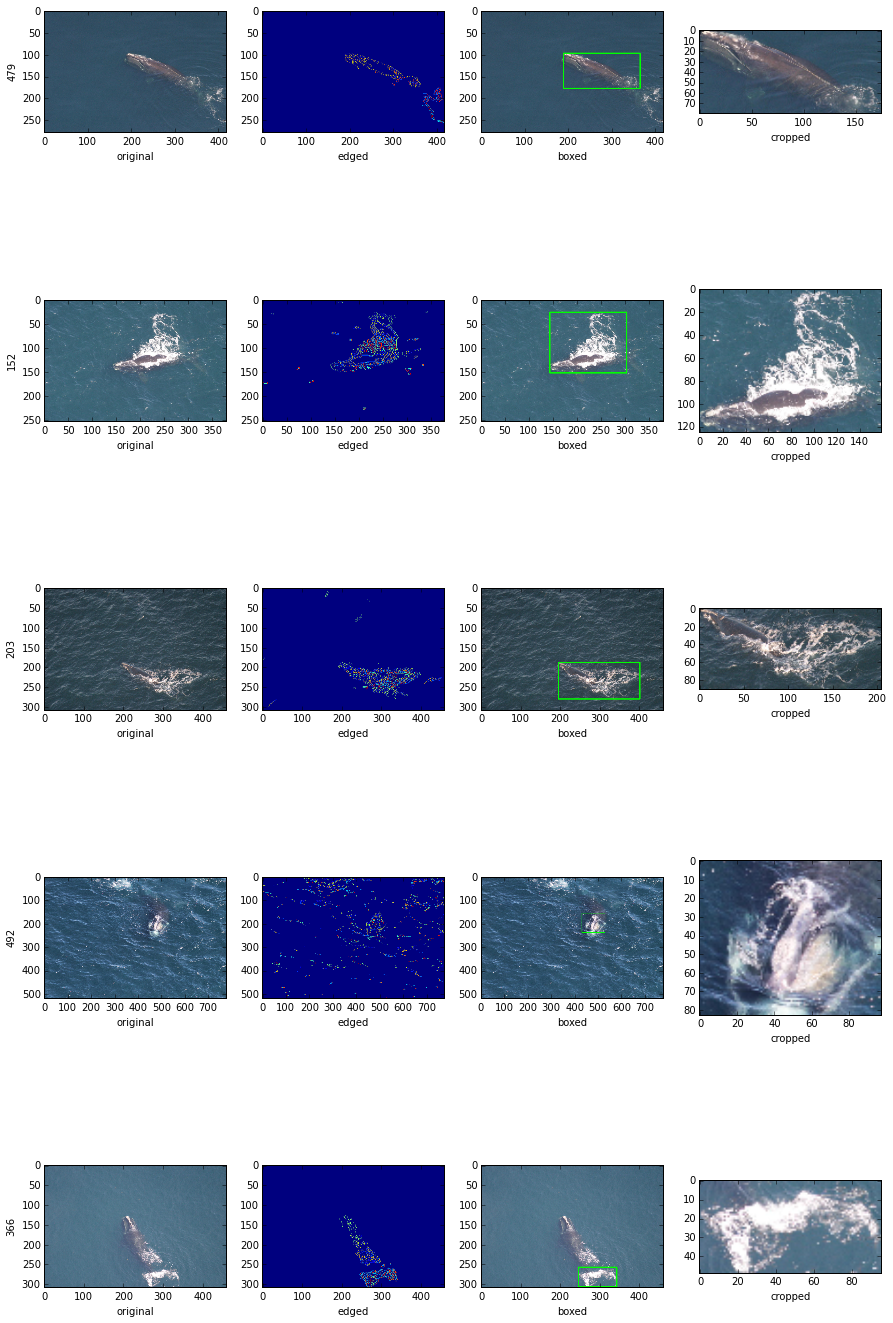

In [25]:
plt.figure(figsize=(15, 25))
img_proc.view_multiple_image(5, len(img_proc.ls_frame))

## not-optimzed images
These images are what I found that is not fitting well for the optimization I did.

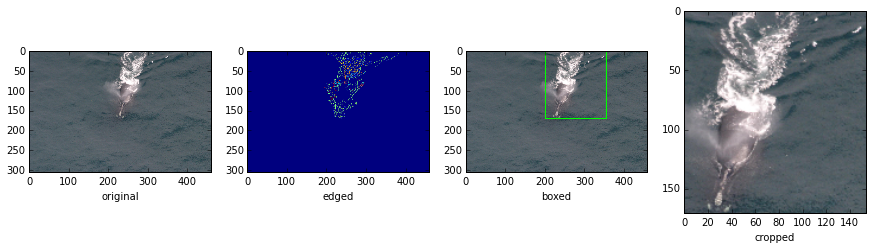

In [26]:
plt.figure(figsize=(15, 10))
img_proc.view_image(33)

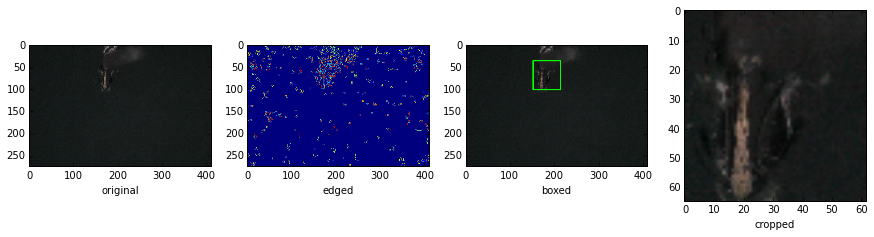

In [27]:
plt.figure(figsize=(15, 10))
img_proc.view_image(28)

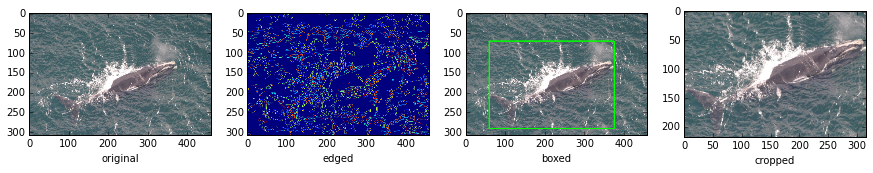

In [28]:
plt.figure(figsize=(15, 10))
img_proc.view_image(38)

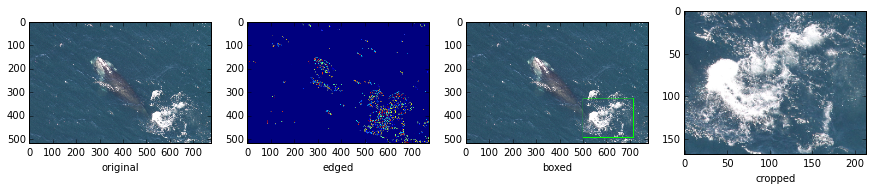

In [29]:
plt.figure(figsize=(15, 10))
img_proc.view_image(30)

#개선사항
1. face만 잘라내야 합니다. 그런데, 파도가 잡히는 것을 확인할 수 있습니다. 
 